# Boostrap Consensus Trees - Poetic Style

BCTs are a way of laying out points according to local similarity. As well as providing meaningful qualitative clustering, the links between nodes can be used to show points that are especially closely connected.

Here we consider only poetic features, as described below

![table](./es_poetics_summary.png)

In [1]:
import numpy as np
import pandas as pd

from typing import Callable, Collection, Union

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from ruzicka.test_metrics import minmax

In [2]:
%load_ext rpy2.ipython

## Poetic Features

The vectorisation is complicated, and done by my `MQDQParser` package ([github](https://github.com/bnagy/mqdq-parser/blob/master/mqdq/elegy.py))

In [3]:
vecs = pd.read_csv("elegy_poetic.csv", index_col=0)

In [4]:
vecs

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,Ovid,Ep.,Ep. 1,0.086207,0.500000,0.500000,0.448276,0.241379,0.706897,0.810345,...,0.0,0.206897,0.068966,0.396552,1.000000,0.094828,4.393948,0.739842,116,0.000000
1,Ovid,Ep.,Ep. 2,0.189189,0.527027,0.581081,0.391892,0.283784,0.743243,0.878378,...,0.0,0.202703,0.067568,0.337838,1.000000,0.114865,4.071062,1.027448,148,0.000000
2,Ovid,Ep.,Ep. 3,0.220779,0.493506,0.519481,0.480519,0.181818,0.597403,0.818182,...,0.0,0.116883,0.025974,0.324675,1.000000,0.090909,3.845700,0.484285,154,0.000000
3,Ovid,Ep.,Ep. 4,0.102273,0.511364,0.545455,0.465909,0.147727,0.659091,0.829545,...,0.0,0.215909,0.045455,0.329545,1.000000,0.073864,3.822098,0.893575,176,0.000000
4,Ovid,Ep.,Ep. 5,0.215190,0.455696,0.632911,0.417722,0.164557,0.658228,0.911392,...,0.0,0.202532,0.037975,0.341772,1.000000,0.056962,3.727347,0.713715,158,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,ps-Ovid,Consolatio,Consolatio 3,0.329114,0.506329,0.658228,0.582278,0.291139,0.594937,0.772152,...,0.0,0.151899,0.037975,0.240506,0.987342,0.202532,4.590044,1.062847,158,0.225018
302,ps-Ovid,Ibis,Ibis 1,0.156250,0.718750,0.562500,0.593750,0.156250,0.562500,0.906250,...,0.0,0.187500,0.000000,0.218750,1.000000,0.109375,3.986751,1.053890,64,0.000000
303,ps-Ovid,Ibis,Ibis 2,0.160000,0.530000,0.620000,0.440000,0.100000,0.580000,0.960000,...,0.0,0.230000,0.060000,0.360000,1.000000,0.130000,4.683774,0.994626,200,0.000000
304,ps-Ovid,Ibis,Ibis 3,0.190000,0.450000,0.730000,0.550000,0.180000,0.730000,0.950000,...,0.0,0.240000,0.050000,0.260000,1.000000,0.060000,4.070276,0.787213,200,0.000000


In [5]:
corpus = vecs[vecs.LEN >= 20]

In [6]:
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(corpus.drop(["Author", "Work", "Poem"], axis=1)))
y = list(corpus.Poem)

In [7]:
X.shape

(298, 43)

## Eder BCT

Boostrap Consensus Tree, as introduced [here](https://computationalstylistics.github.io/projects/bootstrap-networks/) and (more-or-less as) implemented in the _Stylo_ R package. Essentially it's a bootstrap loop where, at each iteration we do a subsample of features (columns) and calculate the 3 nearest neighbours for each point with a given metric. Edges are given 3 points for the nearest neighbour, then 2 for second and 1 for third, and finally all the scores are aggregated to produce a weighted graph. This version allows any feature universe and any metric as a callable. By default we return only the top 20% of the edges (this is an n x n-1 graph, after all).

In [8]:
def eder_bct(
    X: pd.DataFrame,
    y: list[str],
    n: int = 500,
    keep_pct: float = 0.2,
    feats_pct: float = 0.3,
    rng: np.random.Generator = np.random.default_rng(),
    metric: Union[
        Callable[[Collection[float], Collection[float]], float], str
    ] = "cosine",
) -> pd.DataFrame:
    dfs = []
    cl = KNeighborsClassifier(n_neighbors=3, metric=metric)
    for _ in range(n):
        # Sample feats_pct random features (columns)
        this_X = X.sample(int(X.shape[1] * feats_pct), axis=1, random_state=rng)

        # Calculate kNN in that space
        cl.fit(this_X, y)
        dists, indices = cl.kneighbors(n_neighbors=3)

        # And build a dataframe from the results
        dicts = []
        for i, node_ary in enumerate(indices):
            for j, node in enumerate(node_ary):
                dicts.append(
                    {
                        "from": y[i],
                        "to": y[node],
                        # neighbors are sorted low distance to high
                        # so this gives us the 'inverse rank' ie lowest
                        # distance of n neighbors scores n, next is n-1 etc
                        # this is consistent with the stylo BCT algorithm
                        "weight": (len(node_ary) - j),
                    }
                )
        dfs.append(pd.DataFrame(dicts))

    # Now aggregate the dataframes, summing the weights for
    # identical (directed) edges
    graph = pd.concat(dfs).groupby(["from", "to"], as_index=False).agg("sum")
    graph_trim = graph.nlargest(int(len(graph) * keep_pct), "weight")
    return graph_trim

In [9]:
graph_trim = eder_bct(X, y, n=500, rng=np.random.default_rng(seed=42), metric="cosine")

## Cluster Results

The dissimilarity between eg the _Ibis_ and the rest of late Ovid is no longer as obvious because the distinctive lexical and genre issues aren't present in the metrical features. By contrast, the isolation of the _Consolatio_ from the other Augustan elegists is clear, here.

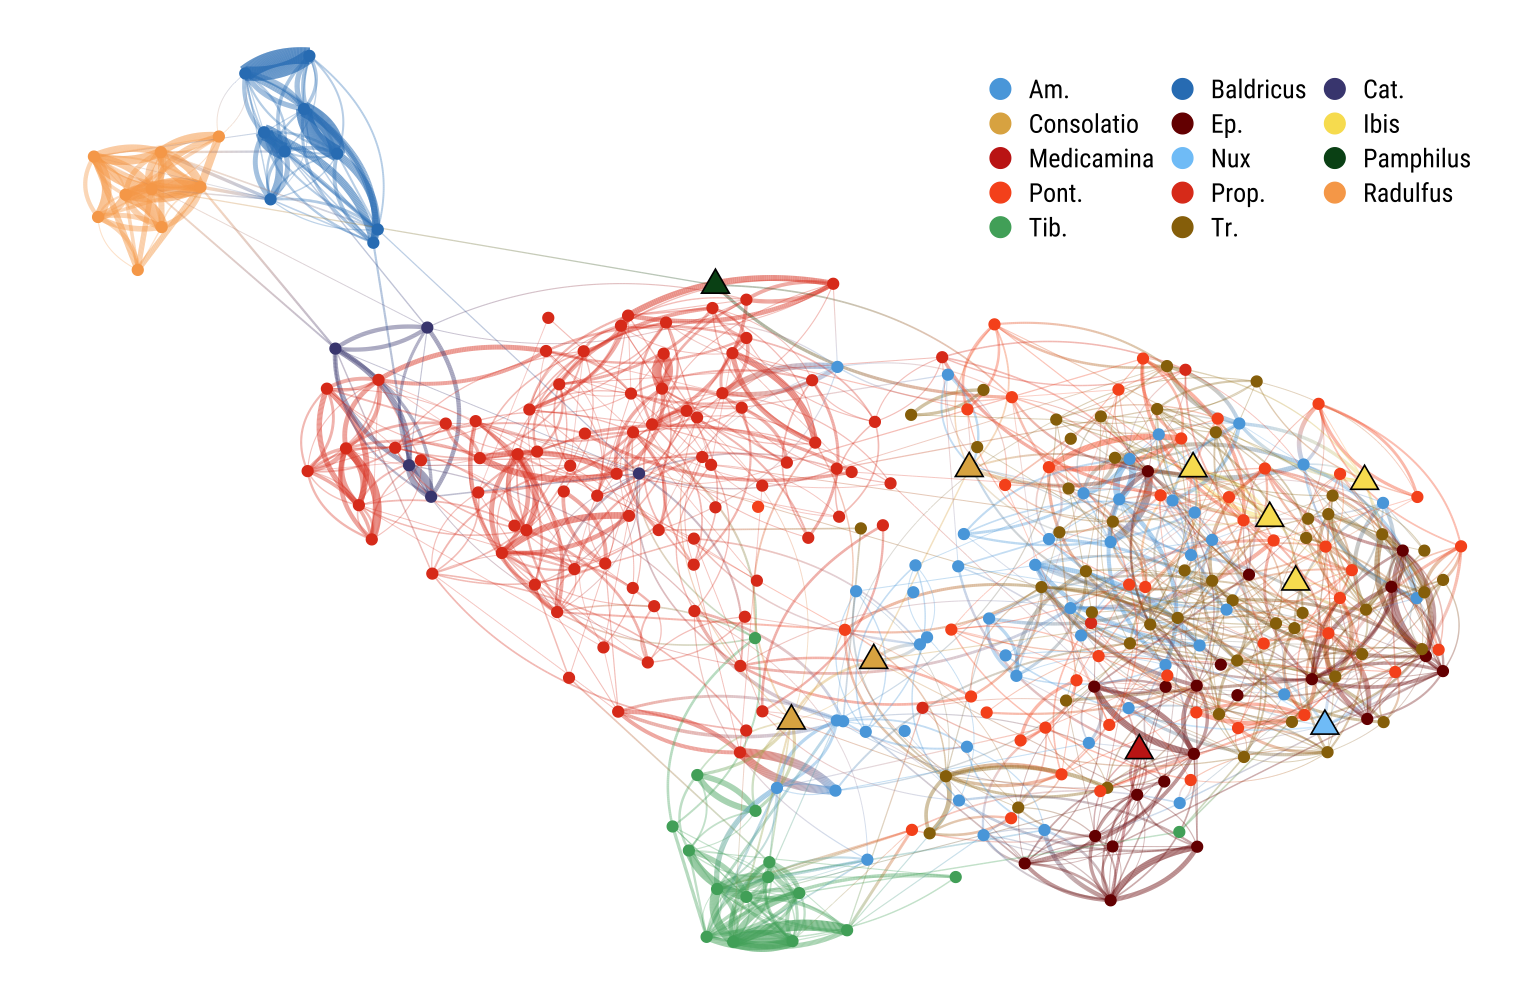

In [ ]:
%%R -i graph_trim  -h 7 -w 10.7 -u in -r 144

source('do_bct.R')
p <- do_bct(
    graph_trim,
    'black',
    'white',
    lim=120,
    highlight_nodes=c("Nux", "Ibis", "Consolatio", "Medicamina", "Pamphilus"),
    legend_pos = c(0.8,0.85),
    flip=F
)
# fn <- "../figures/bct_poet.pdf"
# ggsave(plot=p, fn, dpi=600, width=10.7, height=7, device=cairo_pdf)
p

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jan 20 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.20.0

sklearn: 1.4.2
pandas : 2.2.2
numpy  : 1.26.4

Watermark: 2.5.0

